In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

from scipy.optimize import minimize
from math import sin

FPS = 24

In [4]:
plt.rcParams["figure.figsize"] = (20,10)

In [5]:
# arm radius
r_m = 0.5 # m
m_kg = 4
# arm inertia
theta = m_kg * r_m ** 2
Fg = m_kg * 9.81
# damper
k = 0.1

## disturbances / plant model
r_real_m = r_m + 0.1 # m
k_real = k + 0.1
angle_noise_std = np.deg2rad(2) # rad
angle_vel_noise_std = 0.1 # rad/s
motor_noise_std = 2 # N

def system_dynamics(x, u):  
    x1, x2 = x
    
    dx_dt = [
        x2,
        r_m / theta * (Fg * sin(x1) - u) - k * x2
    ]
    
    return np.array(dx_dt)

def system_dynamics_plant(x, u):  
    x1, x2 = x
    
    # IMU noise
    x1 += np.random.normal(0, angle_noise_std)
    x2 += np.random.normal(0, angle_vel_noise_std)
    # Motor noise
    u += np.random.normal(0, motor_noise_std)
    
    dx_dt = [
        x2,
        (r_real_m) / theta * (Fg * sin(x1) - u) - (k_real) * x2
    ]
    
    return np.array(dx_dt)

assert np.allclose(system_dynamics([np.deg2rad(90), 0], Fg), [0,0])

In [6]:
x0 = np.array([np.deg2rad(90), 0])

duration_s = 60

# this cant be too small for it to work
delT = 0.01
N = 5
n_steps = int(duration_s / delT)

In [7]:
x = x0
xs = [x]
us = [0]

u_traj_init = np.ones(N)
u = None

for i in range(n_steps):
    if u is not None:
        # warm start using state similarity
        # initial value embedding
        u_traj_init = u_opt
    
    Q = [
        [4,0],
        [0,1]
    ]
    
    # this has to be very small because we weight N vs radians
    # i.e. if x and u are weighted the same, a relatively small
    # deviation in u of 1N is weighted the same as ~60°
    R = 0.00001
    
    def obj(u_traj):
        xk = x
        
        # single-shooting
        cost = 0
        for k in range(N):
            uk = u_traj[k]
            
            cost += 1/2 * (xk.T @ Q @ xk + uk * R * uk)
            
            xk1 = xk + delT * system_dynamics(xk, uk)
            xk = xk1
        
        return cost
    
    def jac(u_traj):
        return R * u_traj

    res = minimize(obj, u_traj_init, method="L-BFGS-B")
    
    if not res.success:
        print("optimization failed ", i)
        print(res)
        break
    
    # use first control input
    u_opt = res.x
    u = u_opt[0]
    
    x = x + delT * system_dynamics_plant(x, u)
    
    if i % 100 == 0:
        print(f"In step {i}/{n_steps} u={u:.2f}N, x={x.T}")
    
    us.append(u)
    xs.append(x)

xs = np.array(xs)
us = np.array(us)

In step 0/6000 u=65.02N, x=[ 1.5711107  -0.14431468]
In step 100/6000 u=37.98N, x=[ 1.42078711 -0.14233212]
In step 200/6000 u=36.82N, x=[ 1.2933042 -0.1202681]
In step 300/6000 u=35.17N, x=[ 1.14714034 -0.10939964]
In step 400/6000 u=35.19N, x=[ 1.03632161 -0.12564823]
In step 500/6000 u=30.47N, x=[ 0.92353006 -0.09597435]
In step 600/6000 u=28.13N, x=[ 0.83318023 -0.09022402]
In step 700/6000 u=25.99N, x=[ 0.74386756 -0.05701979]
In step 800/6000 u=27.39N, x=[ 0.6827878  -0.05773699]
In step 900/6000 u=22.74N, x=[ 0.60993026 -0.04302237]
In step 1000/6000 u=21.45N, x=[ 0.55218332 -0.05867453]
In step 1100/6000 u=19.46N, x=[ 0.49982388 -0.06199156]
In step 1200/6000 u=15.04N, x=[ 0.44083152 -0.06548698]
In step 1300/6000 u=16.65N, x=[ 0.39260588 -0.0568895 ]
In step 1400/6000 u=9.07N, x=[ 0.34780942 -0.00560617]
In step 1500/6000 u=12.41N, x=[ 0.31324591 -0.03676325]
In step 1600/6000 u=6.39N, x=[ 0.27162769 -0.03570813]
In step 1700/6000 u=8.16N, x=[ 0.26212399 -0.01820438]
In step 1

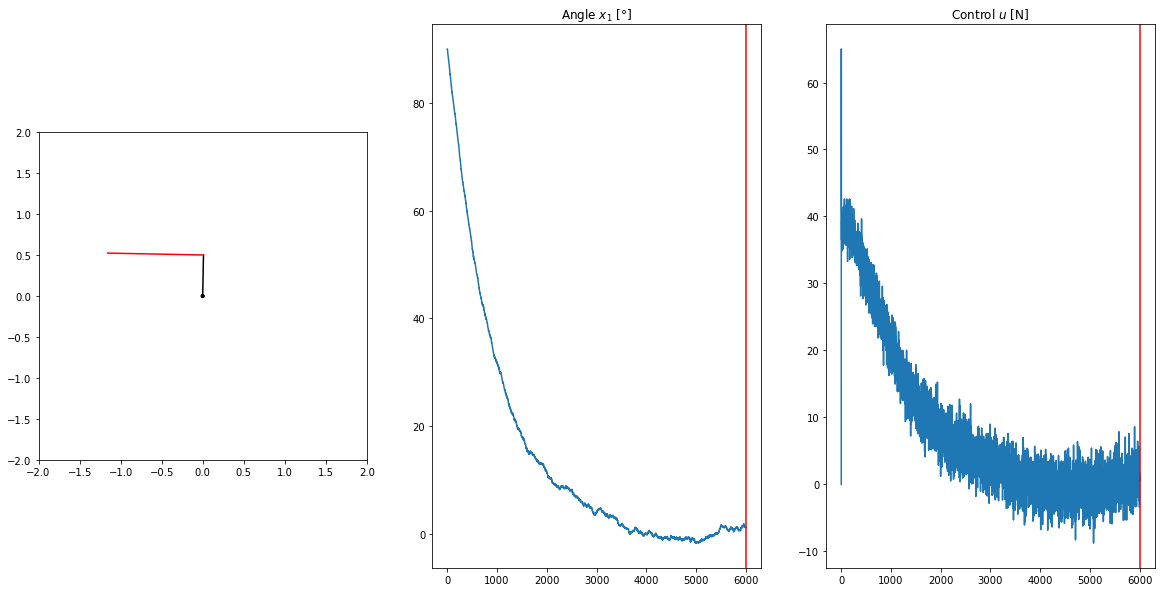

Step 120


In [9]:
hdisplay = display.display("", display_id=True)

fig, axes = plt.subplots(ncols=3)

axes[0].set_xlim((-2,2))
axes[0].set_ylim((-2,2))
axes[0].set_aspect("equal")

axes[1].plot(np.rad2deg(xs[:,0]))
axes[1].set_title("Angle $x_1$ [°]")
oi = axes[1].axvline(0, color="r")

axes[2].plot(us)
axes[2].set_title("Control $u$ [N]")
oi2 = axes[2].axvline(0, color="r")

# center bearing
axes[0].add_artist(plt.Circle([0,0], radius=0.02, color="k"))

line_arm = axes[0].plot([],[], "k")
line_force = axes[0].plot([],[], "r")

step = round(n_steps/50)
print("Step", step)
time_last = 0
for kk, state in enumerate(xs[::step]):
    phi, dphi = state
    k = kk*step
    
    #todo
    r = 0.5
    F = us[k]
    
    x = r * np.sin(phi)
    y = r * np.cos(phi)
    
    x_force = x - F * np.cos(phi)
    y_force = y + F * np.sin(phi)
    
    line_arm[0].set_data([0,x],[0,y])
    line_force[0].set_data([x, x_force],[y, y_force])
    oi.set_xdata(k)
    oi2.set_xdata(k)
    
    hdisplay.update(fig)
    if time.time() - time_last < 1/FPS:
        time.sleep(1/FPS - (time.time() - time_last))
        
    time_last = time.time()
plt.close(fig)

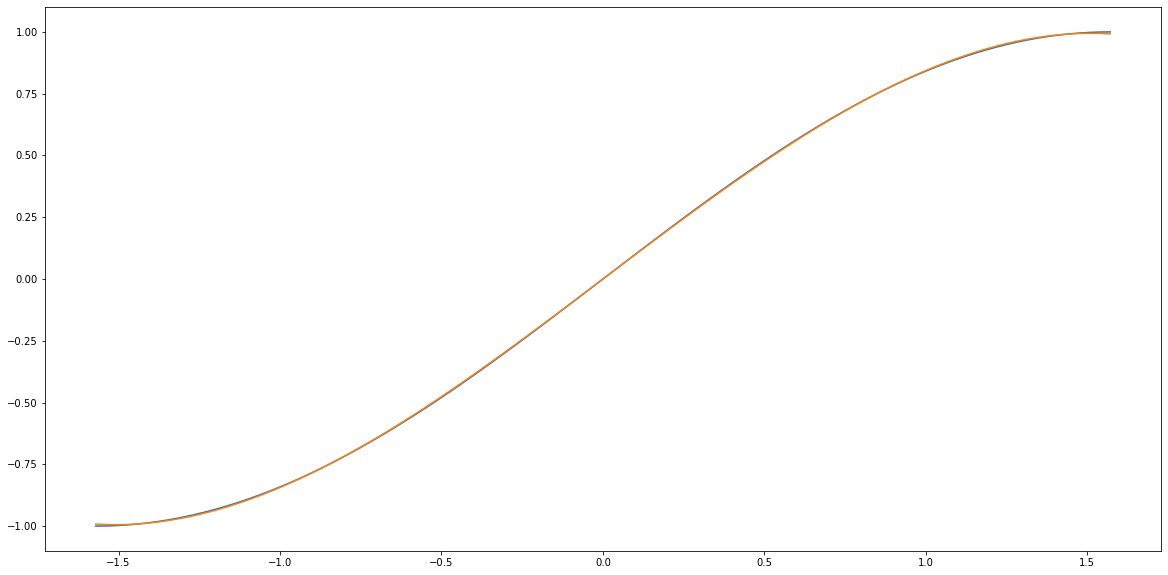

In [25]:
x = np.linspace(-np.pi/2, np.pi/2, 100)
y = np.sin(x)

a, b, c = res.x
y2 = a * x ** 3 + b*x**2 + c*x

plt.plot(x, y)
plt.plot(x, y2)

In [26]:
def obj(params):
    a,b,c = params
    y2 = a * x ** 3 + b*x**2 + c*x
    
    errs = (y2 - y)**2
    return np.sum(errs)

In [27]:
res = minimize(obj, [1,1, 1])
res

      fun: 0.0008428879829111419
 hess_inv: array([[ 1.37292895e-02,  1.54958637e-10, -2.07332469e-02],
       [ 1.54958638e-10,  3.94589984e-03, -2.56358659e-10],
       [-2.07332469e-02, -2.56358658e-10,  3.72691421e-02]])
      jac: array([-5.53773134e-08, -3.78193363e-06,  5.59666660e-08])
  message: 'Optimization terminated successfully.'
     nfev: 32
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([-1.44662351e-01, -7.47235940e-09,  9.88367139e-01])